In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from prod_feature_extraction import *
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
# TODO: Re-construct the network and add dropout after the pooling layer.
#from keras.models import Sequential
#from keras.layers.core import Dense, Activation, Flatten, Dropout
#from keras.models import load_model

In [3]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, hog_color_space="HSV"):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_color_space != 'RGB':
            if hog_color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif hog_color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif hog_color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif hog_color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif hog_color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)   
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        elif hog_channel=='GRAY' :
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                hog_features = get_hog_features(gray, orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features

    return np.concatenate(img_features)
def search_windows(img, windows, clf, scaler, model, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #test_features = scaler.transform(features)
        #6) Predict using your classifier
        prediction = clf.predict(model.transform(test_features))
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 255, 0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

[((560, 350), (620, 410)), ((830, 380), (890, 440)), ((830, 410), (890, 470)), ((860, 440), (920, 500)), ((1010, 440), (1070, 500)), ((1070, 440), (1130, 500)), ((800, 410), (880, 490)), ((840, 410), (920, 490)), ((850, 415), (940, 505)), ((1059, 377), (1139, 457)), ((1066, 377), (1146, 457)), ((821, 384), (901, 464)), ((828, 384), (908, 464)), ((835, 384), (915, 464)), ((856, 384), (936, 464)), ((821, 391), (901, 471)), ((863, 391), (943, 471)), ((870, 391), (950, 471)), ((877, 391), (957, 471)), ((814, 398), (894, 478)), ((828, 398), (908, 478)), ((835, 398), (915, 478)), ((849, 398), (929, 478)), ((856, 398), (936, 478)), ((863, 398), (943, 478)), ((870, 398), (950, 478)), ((877, 398), (957, 478)), ((807, 405), (887, 485)), ((814, 405), (894, 485)), ((828, 405), (908, 485)), ((835, 405), (915, 485)), ((842, 405), (922, 485)), ((849, 405), (929, 485)), ((856, 405), (936, 485)), ((863, 405), (943, 485)), ((870, 405), (950, 485)), ((1066, 405), (1146, 485)), ((814, 412), (894, 492)), (

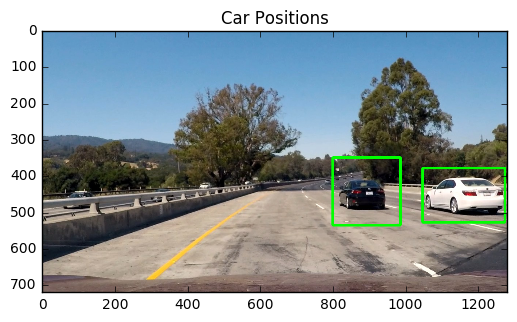

[((512, 428), (712, 628))]


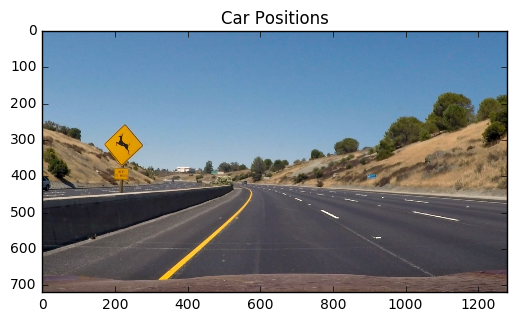

[((890, 410), (950, 470)), ((880, 410), (960, 490)), ((884, 391), (964, 471)), ((870, 398), (950, 478)), ((877, 398), (957, 478)), ((884, 398), (964, 478)), ((891, 398), (971, 478)), ((898, 398), (978, 478)), ((905, 398), (985, 478)), ((870, 405), (950, 485)), ((877, 405), (957, 485)), ((884, 405), (964, 485)), ((891, 405), (971, 485)), ((898, 405), (978, 485)), ((870, 412), (950, 492)), ((877, 412), (957, 492)), ((884, 412), (964, 492)), ((891, 412), (971, 492)), ((898, 412), (978, 492))]


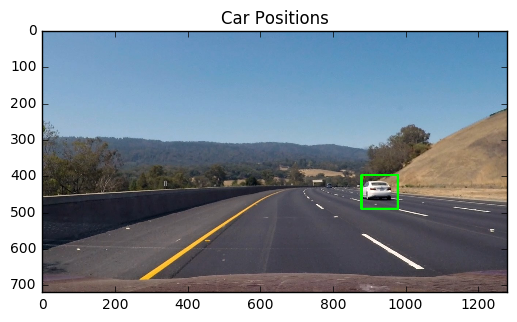

[((830, 380), (890, 440)), ((830, 410), (890, 470)), ((830, 440), (890, 500)), ((860, 440), (920, 500)), ((840, 410), (920, 490)), ((850, 415), (940, 505)), ((1030, 415), (1120, 505)), ((821, 370), (901, 450)), ((828, 370), (908, 450)), ((828, 384), (908, 464)), ((849, 384), (929, 464)), ((856, 384), (936, 464)), ((856, 391), (936, 471)), ((863, 391), (943, 471)), ((828, 398), (908, 478)), ((849, 398), (929, 478)), ((856, 398), (936, 478)), ((863, 398), (943, 478)), ((807, 405), (887, 485)), ((828, 405), (908, 485)), ((835, 405), (915, 485)), ((842, 405), (922, 485)), ((849, 405), (929, 485)), ((863, 405), (943, 485)), ((1045, 405), (1125, 485)), ((1052, 405), (1132, 485)), ((800, 412), (880, 492)), ((807, 412), (887, 492)), ((814, 412), (894, 492)), ((828, 412), (908, 492)), ((835, 412), (915, 492)), ((849, 412), (929, 492)), ((856, 412), (936, 492)), ((863, 412), (943, 492)), ((870, 412), (950, 492)), ((1045, 412), (1125, 492)), ((828, 419), (908, 499)), ((835, 419), (915, 499)), ((8

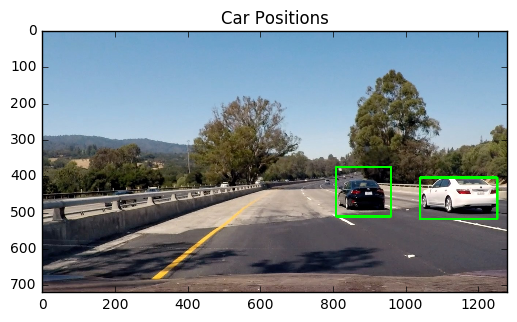

[((1130, 380), (1190, 440)), ((830, 410), (890, 470)), ((860, 410), (920, 470)), ((1130, 410), (1190, 470)), ((840, 370), (920, 450)), ((760, 410), (840, 490)), ((840, 410), (920, 490)), ((850, 415), (940, 505)), ((947, 370), (1027, 450)), ((842, 377), (922, 457)), ((849, 377), (929, 457)), ((835, 384), (915, 464)), ((842, 384), (922, 464)), ((849, 384), (929, 464)), ((856, 384), (936, 464)), ((863, 384), (943, 464)), ((870, 384), (950, 464)), ((877, 384), (957, 464)), ((1115, 384), (1195, 464)), ((842, 391), (922, 471)), ((849, 391), (929, 471)), ((856, 391), (936, 471)), ((863, 391), (943, 471)), ((870, 391), (950, 471)), ((828, 398), (908, 478)), ((835, 398), (915, 478)), ((842, 398), (922, 478)), ((849, 398), (929, 478)), ((856, 398), (936, 478)), ((863, 398), (943, 478)), ((807, 405), (887, 485)), ((814, 405), (894, 485)), ((821, 405), (901, 485)), ((828, 405), (908, 485)), ((835, 405), (915, 485)), ((842, 405), (922, 485)), ((849, 405), (929, 485)), ((856, 405), (936, 485)), ((86

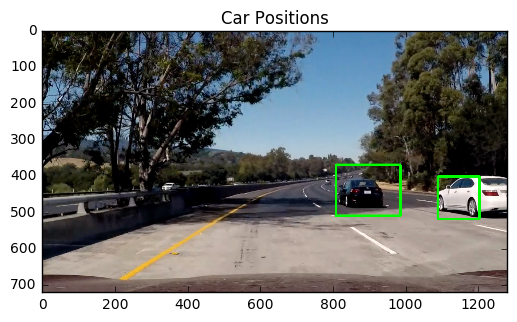

[((920, 380), (980, 440)), ((830, 410), (890, 470)), ((1010, 440), (1070, 500)), ((840, 410), (920, 490)), ((850, 415), (940, 505)), ((835, 384), (915, 464)), ((842, 384), (922, 464)), ((849, 384), (929, 464)), ((856, 384), (936, 464)), ((863, 384), (943, 464)), ((870, 384), (950, 464)), ((835, 391), (915, 471)), ((856, 391), (936, 471)), ((863, 391), (943, 471)), ((870, 391), (950, 471)), ((835, 398), (915, 478)), ((856, 398), (936, 478)), ((863, 398), (943, 478)), ((870, 398), (950, 478)), ((828, 405), (908, 485)), ((835, 405), (915, 485)), ((842, 405), (922, 485)), ((856, 405), (936, 485)), ((863, 405), (943, 485)), ((870, 405), (950, 485)), ((1017, 405), (1097, 485)), ((814, 412), (894, 492)), ((828, 412), (908, 492)), ((835, 412), (915, 492)), ((842, 412), (922, 492)), ((1010, 412), (1090, 492)), ((1017, 412), (1097, 492)), ((828, 419), (908, 499)), ((835, 419), (915, 499)), ((849, 419), (929, 499)), ((856, 419), (936, 499)), ((1122, 419), (1202, 499)), ((821, 426), (901, 506)), (

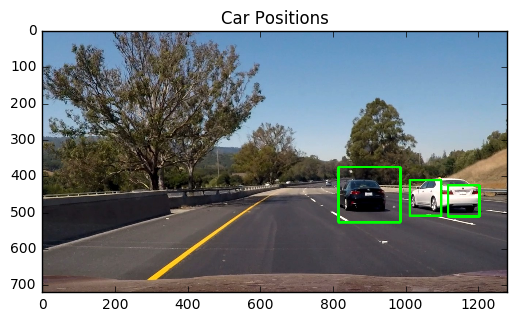

In [10]:
import pickle

# and later you can load it
with open('linearsvc_vehicle_classifier.pkl', 'rb') as f:
    classifier_dict = pickle.load(f)
test_images = glob.glob('test_images/*.jpg')
clf=classifier_dict["classifier"]
model=classifier_dict["feature_select"]
X_scaler = classifier_dict["scaler"]
### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_color_space="HSV"
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (24,24) # Spatial binning dimensions
hist_bins = 20    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [500, None] # Min and max in y to search in slide_window()
i=1
for img_path in test_images:
    image = mpimg.imread(img_path)
    draw_image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    org_image=np.copy(image)
    image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[500, None], y_start_stop=[350,500], 
                        xy_window=(60, 60), xy_overlap=(0.5, 0.5))
    
    windows.extend(slide_window(image, x_start_stop=[400, None], y_start_stop=[370,600], 
                        xy_window=(80, 80), xy_overlap=(0.5, 0.5)))
    
    windows.extend(slide_window(image, x_start_stop=[400, None], y_start_stop=[370,600], 
                        xy_window=(90, 90), xy_overlap=(0.5, 0.5)))
    
    windows.extend(slide_window(image, x_start_stop=[800, None], y_start_stop=[370,600], 
                        xy_window=(80, 80), xy_overlap=(0.9, 0.9)))
    
    windows.extend(slide_window(image, x_start_stop=[400, None], y_start_stop=[370,600], 
                        xy_window=(100, 100), xy_overlap=(0.5, 0.5)))
    
    #windows.extend(slide_window(image, x_start_stop=[700, None], y_start_stop=[370,600], 
    #                    xy_window=(120, 120), xy_overlap=(0.5, 0.5)))
    
    windows.extend(slide_window(image, x_start_stop=[200, None], y_start_stop=[350,700], 
                        xy_window=(135, 135), xy_overlap=(0.8, 0.8)))
    
    windows.extend(slide_window(image, x_start_stop=[200, None], y_start_stop=[350,700], 
                        xy_window=(150, 150), xy_overlap=(0.8, 0.8)))
    
    windows.extend(slide_window(image, x_start_stop=[200, None], y_start_stop=[350,700], 
                        xy_window=(200, 200), xy_overlap=(0.8, 0.8)))
    

    
    
    hot_windows = search_windows(image, windows, clf, X_scaler, model, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    print(hot_windows)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    plt.imshow(window_img)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(org_image, labels)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    
    plt.show()

    
    """plt.imshow(draw_img)
    plt.title('Car Positions')
    
    plt.savefig("testimg"+str(i)+".jpg")
    plt.imshow(window_img)
    plt.title('Detected Windows Positions')
    
    plt.savefig("testimg_window"+str(i)+".jpg")
    i+=1"""

In [48]:
print(X_scaler)

StandardScaler(copy=True, with_mean=True, with_std=True)


In [6]:
import pickle

# and later you can load it
with open('linearsvc_vehicle_classifier.pkl', 'rb') as f:
    classifier_dict = pickle.load(f)
test_images = glob.glob('test_images/*.jpg')

clf=load_model("model.h5")
X_scaler = classifier_dict["scaler"]
### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (24, 24) # Spatial binning dimensions
hist_bins = 20    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [500, None] # Min and max in y to search in slide_window()
for img_path in test_images:
    image = mpimg.imread(img_path)
    draw_image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    org_image=np.copy(image)
    image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[380,630], 
                        xy_window=(96, 96), xy_overlap=(0.8, 0.8))
    
    
    windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=[350,550], 
                       xy_window=(64, 64), xy_overlap=(0.8, 0.8)))
    
    windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=[400,700], 
                        xy_window=(150, 150), xy_overlap=(0.9, 0.9)))
    
    windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=[400,700], 
                        xy_window=(200, 200), xy_overlap=(0.9, 0.9)))
    

    
    
    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    print(hot_windows)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    plt.imshow(window_img)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(org_image, labels)


    
    plt.imshow(draw_img)
    plt.title('Car Positions')
    
    plt.show()

NameError: name 'load_model' is not defined

In [24]:
import pickle

# and later you can load it
with open('linearsvc_vehicle_classifier.pkl', 'rb') as f:
    classifier_dict = pickle.load(f)


clf=load_model("model.h5")
X_scaler = classifier_dict["scaler"]
### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (24, 24) # Spatial binning dimensions
hist_bins = 20    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [500, None] # Min and max in y to search in slide_window()
def video_process_lines(img):
    image = img
    draw_image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    org_image=np.copy(image)
    image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[380,630], 
                        xy_window=(96, 96), xy_overlap=(0.8, 0.8))
    
    
    windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=[350,550], 
                       xy_window=(64, 64), xy_overlap=(0.8, 0.8)))
    
    windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=[400,700], 
                        xy_window=(150, 150), xy_overlap=(0.9, 0.9)))
    
    windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=[400,700], 
                        xy_window=(200, 200), xy_overlap=(0.9, 0.9)))

    
    
    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    plt.imshow(window_img)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(org_image, labels)


    
    return draw_img
    

In [25]:
#cell block 8
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'project.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(video_process_lines) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

TypeError: search_windows() missing 1 required positional argument: 'model'

In [11]:
import pickle
# and later you can load it
with open('linearsvc_vehicle_classifier.pkl', 'rb') as f:
    classifier_dict = pickle.load(f)
test_images = glob.glob('test_images/*.jpg')
clf=classifier_dict["classifier"]
model=classifier_dict["feature_select"]
X_scaler = classifier_dict["scaler"]
### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_color_space="HSV"
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (24,24) # Spatial binning dimensions
hist_bins = 20    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [500, None] # Min and max in y to search in slide_window()
def video_process_lines(img):
    image = img
    draw_image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    org_image=np.copy(image)
    image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[500, None], y_start_stop=[350,500], 
                        xy_window=(60, 60), xy_overlap=(0.5, 0.5))
    
    windows.extend(slide_window(image, x_start_stop=[400, None], y_start_stop=[370,600], 
                        xy_window=(80, 80), xy_overlap=(0.5, 0.5)))
    
    windows.extend(slide_window(image, x_start_stop=[400, None], y_start_stop=[370,600], 
                        xy_window=(90, 90), xy_overlap=(0.5, 0.5)))
    
    windows.extend(slide_window(image, x_start_stop=[800, None], y_start_stop=[370,600], 
                        xy_window=(80, 80), xy_overlap=(0.9, 0.9)))
    
    windows.extend(slide_window(image, x_start_stop=[400, None], y_start_stop=[370,600], 
                        xy_window=(100, 100), xy_overlap=(0.5, 0.5)))
    
    #windows.extend(slide_window(image, x_start_stop=[700, None], y_start_stop=[370,600], 
    #                    xy_window=(120, 120), xy_overlap=(0.5, 0.5)))
    
    windows.extend(slide_window(image, x_start_stop=[200, None], y_start_stop=[350,700], 
                        xy_window=(135, 135), xy_overlap=(0.8, 0.8)))
    
    windows.extend(slide_window(image, x_start_stop=[200, None], y_start_stop=[350,700], 
                        xy_window=(150, 150), xy_overlap=(0.8, 0.8)))
    
    windows.extend(slide_window(image, x_start_stop=[200, None], y_start_stop=[350,700], 
                        xy_window=(200, 200), xy_overlap=(0.8, 0.8)))

    
    
    hot_windows = search_windows(image, windows, clf, X_scaler, model, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    plt.imshow(window_img)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(org_image, labels)


    
    return draw_img

In [12]:
#cell block 8
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'project_processed.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1=clip1.subclip(42,44)
white_clip = clip1.fl_image(video_process_lines) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_processed.mp4
[MoviePy] Writing video project_processed.mp4


100%|█████████▉| 1260/1261 [3:54:08<00:11, 11.02s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_processed.mp4 

Wall time: 3h 54min 9s
